#### **Utils**

In [54]:
import matplotlib.pyplot as plt
import numpy as np


class util(object):
    @staticmethod
    def add_intercept(x):
        """Add intercept to matrix x.

        Args:
            x: 2D NumPy array.

        Returns:
            New matrix same as x with 1's in the 0th column.
        """
        new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
        new_x[:, 0] = 1
        new_x[:, 1:] = x
        return new_x

    @staticmethod
    def load_dataset(csv_path, label_col='y', add_intercept=False):
        """Load dataset from a CSV file.

        Args:
            csv_path: Path to CSV file containing dataset.
            label_col: Name of column to use as labels (should be 'y' or 't').
            add_intercept: Add an intercept entry to x-values.

        Returns:
            xs: Numpy array of x-values (inputs).
            ys: Numpy array of y-values (labels).
        """
        # Validate label_col argument
        allowed_label_cols = ('y', 't')
        if label_col not in allowed_label_cols:
            raise ValueError(
                f'Invalid label_col: {label_col} (expected one of {allowed_label_cols})'
            )

        # Load headers
        with open(csv_path, 'r', encoding='utf-8-sig') as csv_fh:
            headers = csv_fh.readline().strip().split(',')

        # Load features and labels
        l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
        x_cols = [i for i in range(len(headers)) if i not in l_cols]  # <-- This is the main fix
        inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols, encoding='utf-8-sig')
        labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols, encoding='utf-8-sig')


        if inputs.ndim == 1:
            inputs = np.expand_dims(inputs, -1)

        if add_intercept:
            inputs = util.add_intercept(inputs)

        return inputs, labels

    @staticmethod
    def plot(x, y, theta, save_path=None, correction=1.0):
        """Plot dataset and fitted logistic regression parameters.

        Args:
            x: Matrix of training examples, one per row.
            y: Vector of labels in {0, 1}.
            theta: Vector of parameters for logistic regression model.
            save_path: Path to save the plot.
            correction: Correction factor to apply (Problem 2(e) only).
        """
        # Plot dataset
        plt.figure()
        plt.plot(x[:, 1], y, 'bx', label='Data Points')


        x_vals = np.linspace(x[:, -1].min(), x[:, -1].max(), 100)

        # Compute predicted y for these x-values
        # If x includes intercept (column of 1s)
        if x.shape[1] == 2:
            y_vals = theta[0] + theta[1] * x_vals * correction
        else:
            # If no intercept, assume linear model y = theta[0]*x
            y_vals = (theta[0] * x_vals) * correction
        plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Regression line')
        # Add labels and save to disk
        plt.xlabel('x')
        plt.ylabel('y')
        if save_path is not None:
            plt.savefig(save_path)
        plt.show()

# **Linear Regression**

---

## **Loss (Cost) Function**

$$
J(\boldsymbol{\theta}) = \frac{1}{2} 
\sum_{i=1}^{m} \left( h_{\boldsymbol{\theta}}(\mathbf{x}^{(i)}) - y^{(i)} \right)^2
$$

---

## **Hypothesis Function**

$$
h_{\boldsymbol{\theta}}(\mathbf{x}^{(i)}) = 
\boldsymbol{\theta}^\top \mathbf{x}^{(i)}
$$

---

## **Notation Summary**

| Symbol | Meaning |
|:--:|:--|
| $m$ | number of training examples |
| $\mathbf{x}^{(i)}$ | input feature vector of the $i^{th}$ example |
| $y^{(i)}$ | true label for the $i^{th}$ example |
| $\boldsymbol{\theta}$ | parameter (weight) vector |
| $h_{\boldsymbol{\theta}}(x)$ | predicted value (hypothesis) |

---

💡 *Goal:* Find parameters $\boldsymbol{\theta}$ that minimize the cost function $J(\boldsymbol{\theta})$, i.e.  
$$
\boldsymbol{\theta}^* = \arg\min_{\boldsymbol{\theta}} J(\boldsymbol{\theta})
$$


In [55]:
class LinearModel(object):
    """Base class for linear models"""
    def __init__(self, step_size=0.03, max_iter=100, eps=1e-6,
                theta_0=None, verbose=True):
        
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(X, y):
        """Run solver so fit linear model.
        
        Args:
            X: Training example inputs. Shape (m, n)
            y: Training example labels. Shape (m, )
        """

        raise NotImplementedError("Subclass of LinearModel must implement fit method.")

    def predict(self, X):

        """Make a pediction given new inputs x
        Args:
            X: Input of shape(m, n)
        
        Returns:
            Output of shape(m, )"""

        raise NotImplemetedError("Subclass of LinearModel must implement predict method.")
        
    

# **1. Batch Gradient Descent(BGD)**
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Repeat until convergence {

$$
\theta_j := \theta_j + \alpha \sum_{i=1}^{m} (y^{(i)} - h_{\theta}(x^{(i)})) x_j^{(i)} \quad \text{(for every j)}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;}

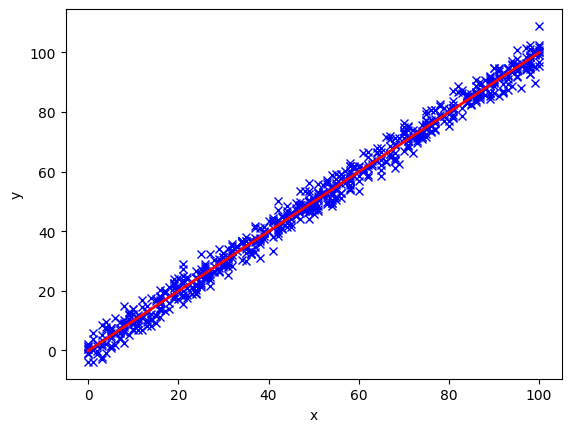

In [56]:
class LinearRegessionBatchGradientDescent(LinearModel):
    def fit(self, X, y):
        m, n = X.shape

        # Initialize parameters
        self.theta = np.zeros(n)
        tmp = 1
        while True:
            theta_old = np.copy(self.theta)
            
            # Correct gradient
            gradient = (1/m) * X.T @ (X @ self.theta - y)
            
            # Update parameters
            self.theta -= self.step_size * gradient
            
            # Check convergence
            if np.linalg.norm(self.theta - theta_old, ord=1) < self.eps:
                break

    def predict(self, X):
        return X @ self.theta

        
def run(train_path, eval_path, pred_path):
    X_train, y_train = util.load_dataset(train_path, add_intercept = True)

    model = LinearRegessionBatchGradientDescent(step_size = 0.0001)
    model.fit(X_train, y_train)

    util.plot(X_train, y_train, model.theta, 'Output/LinearRegessionBatchGradientDescent.png')
    
    X_eval, y_eval = util.load_dataset(eval_path, add_intercept = True)
    

    y_pred = model.predict(X_eval)

    np.savetxt(pred_path, y_pred > 0.5, fmt='%d')

if __name__ == "__main__":
    run(train_path="Data/train.csv", eval_path="Data/test.csv", pred_path="Output/LinearRegessionBatchGradientDescent.txt")

    

# **2. Stochatic Gradient Descent(BGD)**
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Loop {

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; for i=1 to m, {

$$
\theta_j := \theta_j + \alpha (y^{(i)} - h_{\theta}(x^{(i)})) x_j^{(i)} \quad \text{(for every j)}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;}

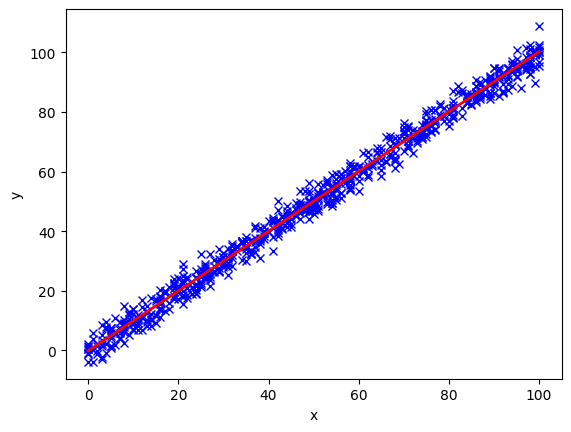

In [57]:
class LinearRegressionStochaticGradientDescent(LinearModel):

    def fit(self, X, y):
        m, n = X.shape

        # Initialize parameters
        self.theta = np.zeros(n)
        tmp = 100
        while tmp:
            tmp -= 1
            theta_old = np.copy(self.theta)

            # Shuffle data each epoch
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Update weights per sample
            for i in range(m):
                xi = X_shuffled[i]           # shape (n,)
                yi = y_shuffled[i]
                error = xi @ self.theta - yi
                gradient = error * xi        # correct gradient
                self.theta -= self.step_size * gradient

            # Early stopping if small change
            if np.linalg.norm(self.theta - theta_old, ord=1) < self.eps:
                break

    def predict(self, X):
        return X @ self.theta        

def run(train_path, eval_path, pred_path):
    X_train, y_train = util.load_dataset(train_path, add_intercept = True)

    model = LinearRegressionStochaticGradientDescent(step_size = 0.0001)
    model.fit(X_train, y_train)


    util.plot(X_train, y_train, model.theta, 'Output/LinearRegressionStochaticGradientDescent.png')
    
    X_eval, y_eval = util.load_dataset(eval_path, add_intercept = True)
    

    y_pred = model.predict(X_eval)

    np.savetxt(pred_path, y_pred > 0.5, fmt='%d')

if __name__ == "__main__":
    run(train_path="Data/train.csv", eval_path="Data/test.csv", pred_path="Output/LinearRegressionStochaticGradientDescent.txt")

# **3. Normal Equation**
### **3.1 Matrix derivatives**
For a function $f: \mathbb{R}^{m \times n} \mapsto \mathbb{R}$ mapping from m-by-n matrices to the real numbers, we define the derivative of $f$ with respect to $A$ to be:

$$
\nabla_A f(A) =
\begin{bmatrix}
\frac{\partial f}{\partial A_{11}} & \dots & \frac{\partial f}{\partial A_{1n}} \\
\vdots & \ddots & \vdots \\
\frac{\partial f}{\partial A_{m1}} & \dots & \frac{\partial f}{\partial A_{mn}}
\end{bmatrix}
$$
### **3.2 Least squares revisited**

Given a training setm define the **design matrix X** to be the m-by-n matrix(actually m-by-n + 1 if we include the intercept term) that containsthe training examples' input values in its rows:

$$
X =
\begin{bmatrix}
— (x^{(1)})^T — \\
— (x^{(2)})^T — \\
\vdots \\
— (x^{(m)})^T —
\end{bmatrix}
$$

Also, let $\vec{y}$ be the $m$-dimensional vector containing all the target values from the training set:

$$
\vec{y} =
\begin{bmatrix}
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(m)}
\end{bmatrix}
$$

Now, since $h_{\theta}(x^{(i)}) = (x^{(i)})^T \theta$, we can easily verify that

$$
\begin{aligned}
X\theta - \vec{y} &=
\begin{bmatrix}
(x^{(1)})^T \theta \\
\vdots \\
(x^{(m)})^T \theta
\end{bmatrix}
-
\begin{bmatrix}
y^{(1)} \\
\vdots \\
y^{(m)}
\end{bmatrix} \\
&=
\begin{bmatrix}
h_{\theta}(x^{(1)}) - y^{(1)} \\
\vdots \\
h_{\theta}(x^{(m)}) - y^{(m)}
\end{bmatrix}
\end{aligned}
$$

Thus, using the fact that for a vector $z$, we have that $z^T z = \sum_i z_i^2$:

$$
\begin{aligned}
\frac{1}{2} (X\theta - \vec{y})^T (X\theta - \vec{y}) &= \frac{1}{2} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})^2 \\
&= J(\theta)
\end{aligned}
$$

Finally, to minimize $J$, let's find its derivatives with respect to $\theta$. 

$$
\nabla_A \text{tr} ABA^T C = B^T A^T C^T + B A^T C \quad (5)
$$

Hence,

$$
\begin{aligned}
\nabla_{\theta} J(\theta) &= \nabla_{\theta} \frac{1}{2} (X\theta - \vec{y})^T (X\theta - \vec{y}) \\
&= \frac{1}{2} \nabla_{\theta} (\theta^T X^T X \theta - \theta^T X^T \vec{y} - \vec{y}^T X \theta + \vec{y}^T \vec{y}) \\
&= \frac{1}{2} \nabla_{\theta} \text{tr} (\theta^T X^T X \theta - \theta^T X^T \vec{y} - \vec{y}^T X \theta + \vec{y}^T \vec{y}) \\
&= \frac{1}{2} \nabla_{\theta} (\text{tr} \theta^T X^T X \theta - 2 \text{tr} \vec{y}^T X \theta) \\
&= \frac{1}{2} (X^T X \theta + X^T X \theta - 2 X^T \vec{y}) \\
&= X^T X \theta - X^T \vec{y}
\end{aligned}
$$

In the third step, we used the fact that the trace of a real number is just the real number; the fourth step used the fact that $\text{tr} A = \text{tr} A^T$, and the fifth step used Equation (5) with $A^T = \theta$, $B = B^T = X^T X$, and $C = I$, and Equation (1). To minimize $J$, we set its derivatives to zero, and obtain the **normal equations**:

$$
X^T X \theta = X^T \vec{y}
$$

Thus, the value of $\theta$ that minimizes $J(\theta)$ is given in closed form by the equation

**$$
\theta = (X^T X)^{-1} X^T \vec{y}.
$$**

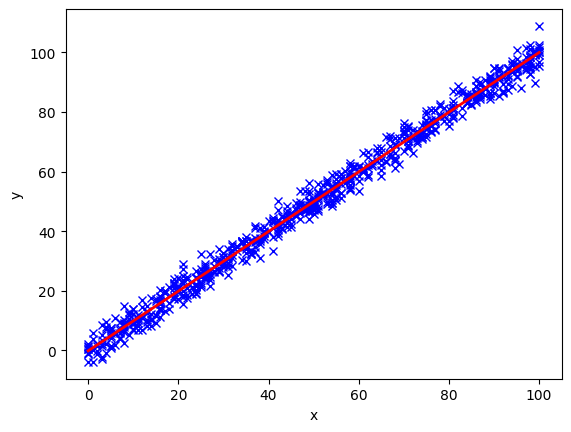

In [58]:
class LinearRegressionNormalEquation(LinearModel):
    def fit(self, X, y):
        # Normal equation: θ = (XᵀX)⁻¹ Xᵀy
        self.theta = np.linalg.pinv(X.T @ X) @ X.T @ y

    def predict(self, X):
        return X @ self.theta
        
def run(train_path, eval_path, pred_path):
    X_train, y_train = util.load_dataset(train_path, add_intercept = True)

    model = LinearRegressionNormalEquation()
    model.fit(X_train, y_train)

    util.plot(X_train, y_train, model.theta, 'Output/LinearRegressionNormalEquation.png')
    
    X_eval, y_eval = util.load_dataset(eval_path, add_intercept = True)
    

    y_pred = model.predict(X_eval)

    np.savetxt(pred_path, y_pred > 0.5, fmt='%d')

if __name__ == "__main__":
    run(train_path="Data/train.csv", eval_path="Data/test.csv", pred_path="Output/LinearRegressionNormalEquation.txt")
    

# **4. Locally Weighted Linear Regression**
The locally weighted linear regression algorithm does the following:

1.  Fit $\theta$ to minimize $\sum_{i} w^{(i)} (y^{(i)} - \theta^T x^{(i)})^2$.
2.  Output $\theta^T x$.

A fairly standard choice for the weights is

$$
w^{(i)} = \exp \left( - \frac{(x^{(i)} - x)^2}{2\tau^2} \right)
$$

MSE=10.097219148814128


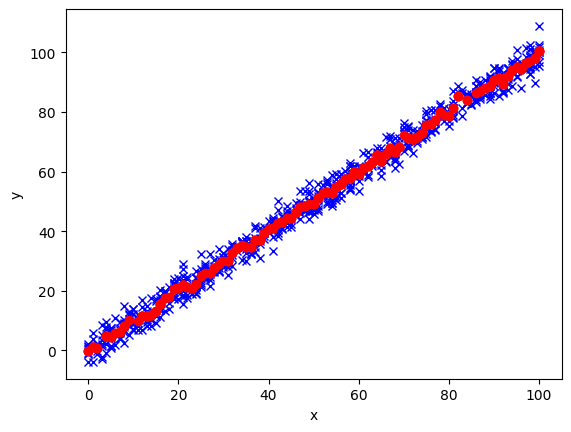

In [59]:
class LocallyWeightedLinearRegression(LinearModel):
    def __init__(self, tau):
        super(LocallyWeightedLinearRegression, self).__init__()
        self.tau = tau
        self.X = None
        self.y = None

    def fit(self, X, y):
        """Store training data."""
        self.X = X
        self.y = y

    def predict(self, X):
        """Make predictions given inputs X.
        
        Args:
            X: shape (m, n)
        Returns:
            y_pred: shape (m,)
        """
        m, n = X.shape
        y_pred = np.zeros(m)

        for i in range(m):
            # compute weights for each training sample relative to query X[i]
            diff = self.X - X[i]                     # (m, n)
            W = np.diag(np.exp(-np.sum(diff**2, axis=1) / (2 * self.tau**2)))

            # solve for theta = (X^T W X)^(-1) X^T W y
            A = self.X.T @ W @ self.X
            b = self.X.T @ W @ self.y
            # regularization for stability
            theta = np.linalg.solve(A + 1e-5 * np.eye(n), b)

            # predict y_hat = x_i^T theta
            y_pred[i] = X[i] @ theta

        return y_pred

def run(train_path, eval_path, tau=5e-1):
    x_train, y_train = util.load_dataset(train_path, add_intercept=True)
    
    model = LocallyWeightedLinearRegression(tau=tau)
    model.fit(x_train, y_train)

    x_eval, y_eval = util.load_dataset(eval_path, add_intercept=True)
    y_pred = model.predict(x_eval)

    mse = np.mean((y_pred - y_eval) ** 2)
    print(f'MSE={mse}')

    plt.figure()
    plt.plot(x_train[:, -1], y_train, 'bx', linewidth=2)  
    plt.plot(x_eval[:, -1], y_pred, 'ro', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('Output/LocallyWeightedLinearRegression.png')

    
if __name__ == "__main__":
    run(train_path="Data/train.csv", eval_path="Data/test.csv")